In [1]:
# Import

import epics
import numpy
import pandas
import torch
import nufft
import yaml

import sys
sys.path.append('..')

from harmonica.util import LIMIT, data_load
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


# Example-01: Estimation of parameters (harmonic sum)

In [2]:
# Estimate parameters and standard errors (random frequency)

# Set parameters
length = 1024
dtype = torch.float64
device = 'cpu'

# Set window
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Set noise parameters
s_x = torch.tensor([0.05, 0.01], dtype=dtype, device=device)
s_f = 1.0E-5

# Set data
t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
x = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.1), 0.75*torch.cos(2.0*numpy.pi*0.12*t + 0.5)])

# Estimate parameters and errors (direct)
p1, s1 = Decomposition.harmonic_sum(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)

# Estimate parameters and errors (automatic)
p2, s2 = Decomposition.harmonic_sum_automatic(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)

# Estimate errors (average over noise realizations)
box = []
for _ in range(8192):
    y = x + s_x.reshape(-1, 1)*torch.randn_like(x, dtype=dtype, device=device)
    out, _ = Decomposition.harmonic_sum(0.12 + 1.0E-5*torch.randn(1, dtype=dtype, device=device), w.window, y)
    box.append(out)    
box = torch.stack(box).T.std(-1).T

# Compare parameters
print(p1)
print(p2)
print()

# Compare errors
print(s1)
print(s2)
print(box)
print()

tensor([[2.487510441567e-01, -2.495835633644e-02, 2.500000030401e-01, 1.000000075225e-01],
        [6.581869317981e-01, -3.595691566478e-01, 7.500000104014e-01, 4.999999965175e-01]],
       dtype=torch.float64)
tensor([[2.487510441567e-01, -2.495835633644e-02, 2.500000030401e-01, 1.000000075225e-01],
        [6.581869317981e-01, -3.595691566478e-01, 7.500000104014e-01, 4.999999965175e-01]],
       dtype=torch.float64)

tensor([[2.822920460161e-03, 8.447543997630e-03, 2.706329386825e-03, 3.394245931339e-02],
        [1.157996334008e-02, 2.118073069991e-02, 5.412658773651e-04, 3.217800267359e-02]],
       dtype=torch.float64)
tensor([[2.822920460161e-03, 8.447543997630e-03, 2.706329386825e-03, 3.394245931339e-02],
        [1.157996334008e-02, 2.118073069991e-02, 5.412658773651e-04, 3.217800267359e-02]],
       dtype=torch.float64)
tensor([[2.818646463342e-03, 8.365337896156e-03, 2.701691016425e-03, 3.361714419655e-02],
        [1.139380263342e-02, 2.082923697532e-02, 5.397655070748e-04, 

# Example-02: Estimation of parameters (harmonic sum & batched mode)

In [3]:
# Estimate parameters and errors for a batch of frequencies

# Set parameters
length = 1024
dtype = torch.float64
device = 'cpu'

# Set window
w = Window.from_cosine(length, 1.0, dtype=torch.float64, device='cpu')

# Set noise parameters
s_x = torch.tensor([0.05, 0.01], dtype=dtype, device=device)
s_f = 1.0E-5

# Set data
t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
x1 = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.10), 0.75*torch.cos(2.0*numpy.pi*0.12*t + 0.60)])
x2 = torch.stack([0.10*torch.cos(2.0*numpy.pi*0.24*t + 0.25), 0.25*torch.cos(2.0*numpy.pi*0.24*t + 0.15)])
x3 = torch.stack([0.05*torch.cos(2.0*numpy.pi*0.36*t + 0.10), 0.01*torch.cos(2.0*numpy.pi*0.36*t + 0.50)])
x = x1 + x2 + x3

# Compute parameters and errors for each frequency (direct)
p1a, s1a = Decomposition.harmonic_sum(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p1b, s1b = Decomposition.harmonic_sum(0.24, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p1c, s1c = Decomposition.harmonic_sum(0.36, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p1 = torch.stack([p1a, p1b, p1c])
s1 = torch.stack([s1a, s1b, s1c])

# Compute parameters and errors for each frequency (automatic)
p2a, s2a = Decomposition.harmonic_sum_automatic(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p2b, s2b = Decomposition.harmonic_sum_automatic(0.24, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p2c, s2c = Decomposition.harmonic_sum_automatic(0.36, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p2 = torch.stack([p2a, p2b, p2c])
s2 = torch.stack([s2a, s2b, s2c])

# Compute parameters and errors for each frequency (batched)
p3, s3 = Decomposition.harmonic_sum_batched(
    torch.tensor([0.12, 0.24, 0.36], dtype=dtype, device=device),
    w.window,
    x,
    error=True,
    sigma=s_x,
    sigma_frequency=torch.tensor([s_f, s_f, s_f], dtype=dtype, device=device))

# Compare errors
print(s1)
print(s2)
print(s3)

tensor([[[2.822920601761e-03, 8.447544296222e-03, 2.706329386825e-03, 3.394245973862e-02],
         [1.363412168625e-02, 1.992058457734e-02, 5.412658773653e-04, 3.217800385559e-02]],

        [[2.820933989700e-03, 4.127929982633e-03, 2.706329386827e-03, 4.203956358381e-02],
         [1.318111090385e-03, 7.970572419377e-03, 5.412658773716e-04, 3.224269320318e-02]],

        [[2.711089283224e-03, 3.144152029843e-03, 2.706329386826e-03, 6.296499040365e-02],
         [5.628105253876e-04, 6.104693260486e-04, 5.412658773675e-04, 6.296490438044e-02]]],
       dtype=torch.float64)
tensor([[[2.822920601761e-03, 8.447544296222e-03, 2.706329386825e-03, 3.394245973862e-02],
         [1.363412168625e-02, 1.992058457734e-02, 5.412658773653e-04, 3.217800385559e-02]],

        [[2.820933989700e-03, 4.127929982633e-03, 2.706329386827e-03, 4.203956358381e-02],
         [1.318111090385e-03, 7.970572419377e-03, 5.412658773716e-04, 3.224269320318e-02]],

        [[2.711089283224e-03, 3.144152029843e-03, 2.

In [4]:
# Estimate parameters for a list of harmonics

# Set parameters
length = 2048
dtype = torch.float64
device = 'cpu'

# Set window
w = Window.from_cosine(length, 4.0, dtype=torch.float64, device='cpu')

# Set data
t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
x1 = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.10)])
x2 = torch.stack([0.10*torch.cos(2.0*numpy.pi*0.24*t + 0.25)])
x3 = torch.stack([0.05*torch.cos(2.0*numpy.pi*0.36*t + 0.10)])
x = x1 + x2 + x3

# Set harmonics
f = 0.12
h = torch.tensor([*Frequency.harmonics(10, [f]).values()], dtype=dtype, device=device)

# Estimate parameters
param, _ = Decomposition.harmonic_sum_batched(h, w.window, x, error=False)

# Result (amplitude)
*_, a, _ = param.T
print(a.T)

tensor([[2.500000000000e-01],
        [1.000000000000e-01],
        [5.000000000000e-02],
        [2.623619031558e-16],
        [4.015512494878e-16],
        [3.147267753522e-16],
        [1.854150954133e-16],
        [1.135456674832e-16],
        [7.519772959361e-16],
        [2.807503616015e-16]], dtype=torch.float64)


# Example-03: Estimator bias

w1: 2.09465512e-05 2.2936407e-06
w2: 3.7373038e-09 4.98039843e-09


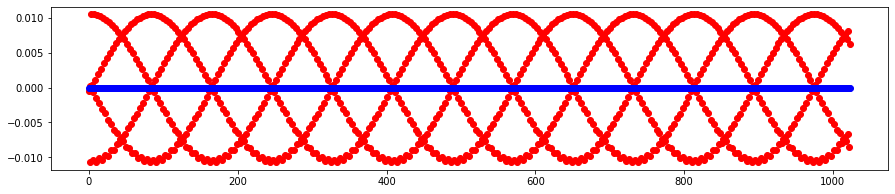

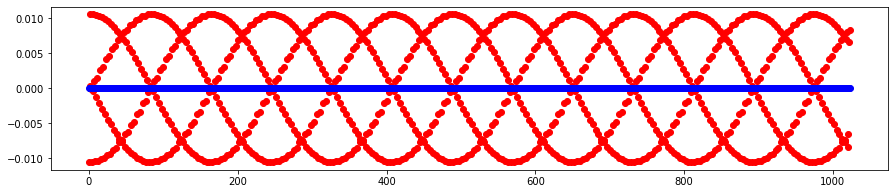

In [5]:
# Given a noise-free signal containing several components
# Parameters for a given frequency can be estimated using (weighted) harmonic sum
# Estimated values depend on the length used for estimation and as well as on the signal starting position
# In this example, estimator bias is explored
# Ensembling several estimators (fixed length and different starting position) in general will improve estimation accuracy (reduce bias)

# Set parameters
length = 8192
dtype = torch.float64
device = 'cpu'

# Set signal
t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
f = 0.123456789
x = 1.0*torch.cos(0.25 + 2.0*numpy.pi*f*t) + 0.01*torch.cos(0.5 + 2.0*numpy.pi*2*f*t)
x = torch.stack([x])

# Set shift size for starting position
shift = 1

# Set window
w1 = Window.from_cosine(128, 0.0, dtype=dtype, device=device)
w2 = Window.from_cosine(128, 1.0, dtype=dtype, device=device)

# Estimate amplitude and phase using shifted samples of length 128
# Change window order, sample length and/or number of samples to observe convergents
limit = 1024
A1, B1 = [], []
A2, B2 = [], []
for step in range(limit):
    
    y = x[:, step*shift: step*shift + 128]
    
    param, _ = Decomposition.harmonic_sum(f, w1.window, y)
    *_, a, b = param.T
    A1.append(a)
    B1.append(b)
    
    param, _ = Decomposition.harmonic_sum(f, w2.window, y)
    *_, a, b = param.T
    A2.append(a)
    B2.append(b)
    
# Format result (amplitude is constant, while phase is shifted)
A1 = torch.stack(A1).flatten()
B1 = torch.stack(B1).flatten()
B1 = Frequency.mod(B1 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)
A2 = torch.stack(A2).flatten()
B2 = torch.stack(B2).flatten()
B2 = Frequency.mod(B2 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)

# Compare mean values over samples
print(f'w1: {torch.abs(A1.mean() - 1.0):12.9} {torch.abs(B1.mean() - 0.25):12.9}')
print(f'w2: {torch.abs(A2.mean() - 1.0):12.9} {torch.abs(B2.mean() - 0.25):12.9}')

# Plot estimations for each sample
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), A1 - 1.00, c='red')
plt.scatter(range(limit), A2 - 1.00, c='blue')
plt.show()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), B1 - 0.25, c='red')
plt.scatter(range(limit), B2 - 0.25, c='blue')
plt.show()

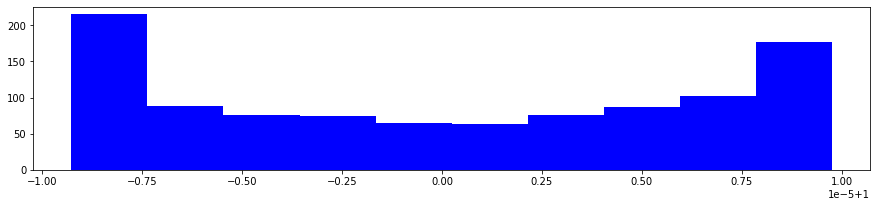

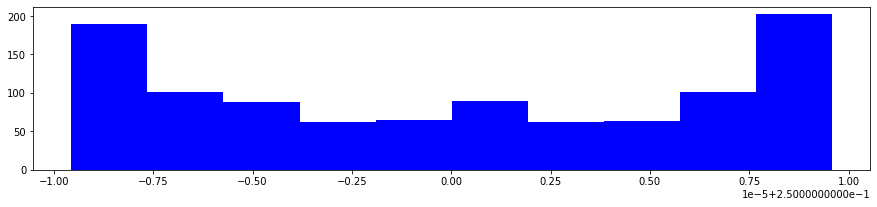

In [6]:
# Plot histogram

plt.figure(figsize=(15, 3))
plt.hist(A2.cpu().numpy(), color='blue')
plt.show()

plt.figure(figsize=(15, 3))
plt.hist(B2.cpu().numpy(), color='blue')
plt.show()

# Other cases have similar histograms
# Note, distribution is not normal (not random)
# It is not symmetric if signal containes more than one component

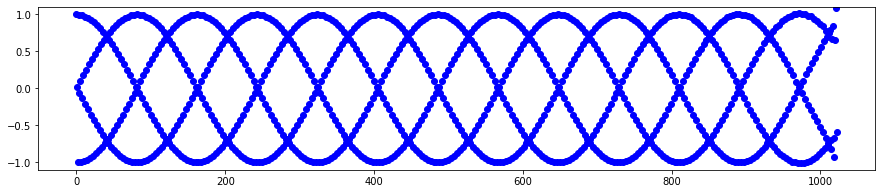

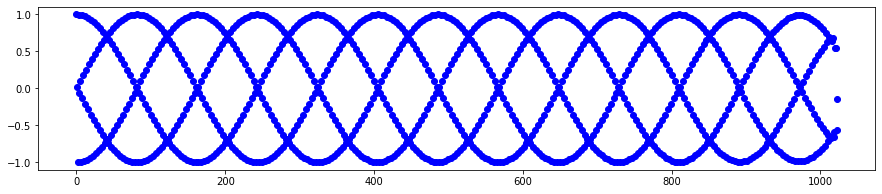

In [7]:
# Plot autocorrelation of estimations

AC = Frequency.autocorrelation(torch.stack([A2-A2.mean()])).flatten()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

AC = Frequency.autocorrelation(torch.stack([B2-B2.mean()])).flatten()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

w1: 6.78055376e-05 6.37358749e-06
w2: 4.77219848e-05 3.09173025e-06


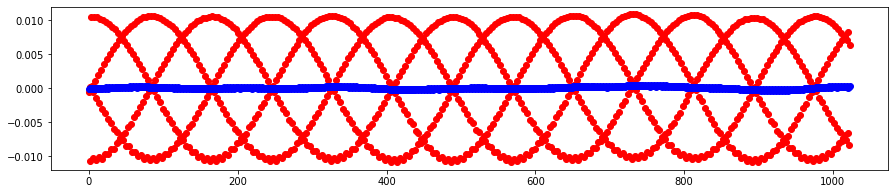

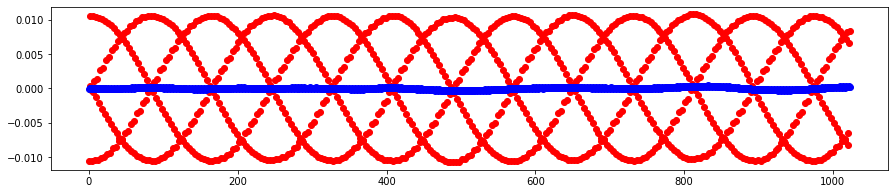

In [8]:
# Estimate parameters for signal with noise

# Set parameters
length = 8192
dtype = torch.float64
device = 'cpu'

# Set signal
t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
f = 0.123456789
x = 1.0*torch.cos(0.25 + 2.0*numpy.pi*f*t) + 0.01*torch.cos(0.5 + 2.0*numpy.pi*2*f*t)
x.add_(0.001*torch.randn(length, dtype=dtype, device=device))
x = torch.stack([x])

# Set shift size for starting position
shift = 1

# Set window
# Note, without noise window increases convergence
# With noise window amplifies noise and should be use with care if noise is large
# A possible option is to filter data or to use fractional window order
w1 = Window.from_cosine(128, 0.0, dtype=dtype, device=device)
w2 = Window.from_cosine(128, 0.5, dtype=dtype, device=device)

# Estimate amplitude and phase using shifted samples of length 128
# Note, noise is correlated
A1, B1 = [], []
A2, B2 = [], []
for step in range(limit):
    y = x[:, step*shift: step*shift + 128]
    param, _ = Decomposition.harmonic_sum(f, w1.window, y)
    *_, a, b = param.T
    A1.append(a)
    B1.append(b)
    param, _ = Decomposition.harmonic_sum(f, w2.window, y)
    *_, a, b = param.T
    A2.append(a)
    B2.append(b)

# Format result (amplitude is constant, while phase is shifted)
A1 = torch.stack(A1).flatten()
B1 = torch.stack(B1).flatten()
B1 = Frequency.mod(B1 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)
A2 = torch.stack(A2).flatten()
B2 = torch.stack(B2).flatten()
B2 = Frequency.mod(B2 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)

# Compare mean values over samples
print(f'w1: {torch.abs(A1.mean() - 1.0):12.9} {torch.abs(B1.mean() - 0.25):12.9}')
print(f'w2: {torch.abs(A2.mean() - 1.0):12.9} {torch.abs(B2.mean() - 0.25):12.9}')

# Plot estimations for each sample
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), A1 - 1.00, c='red')
plt.scatter(range(limit), A2 - 1.00, c='blue')
plt.show()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), B1 - 0.25, c='red')
plt.scatter(range(limit), B2 - 0.25, c='blue')
plt.show()

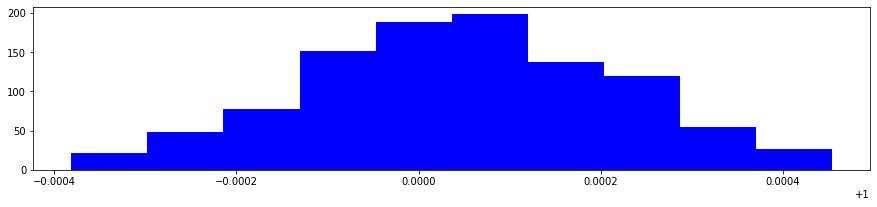

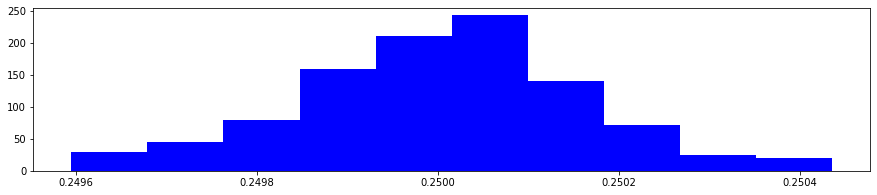

In [9]:
# Plot histogram

plt.figure(figsize=(15, 3))
plt.hist(A2.cpu().numpy(), color='blue')
plt.show()

plt.figure(figsize=(15, 3))
plt.hist(B2.cpu().numpy(), color='blue')
plt.show()

# Other cases have similar histograms
# Note, distribution looks somewhat not normal

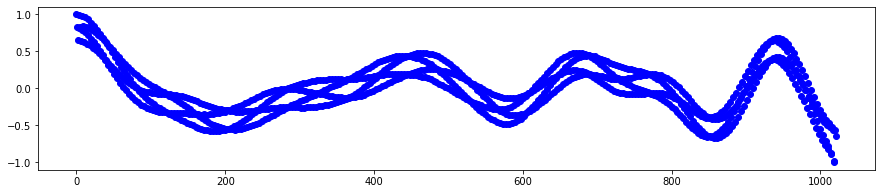

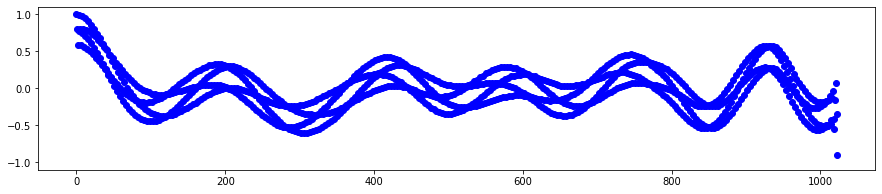

In [10]:
# Plot autocorrelation of estimations

AC = Frequency.autocorrelation(torch.stack([A2-A2.mean()])).flatten()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

AC = Frequency.autocorrelation(torch.stack([B2-B2.mean()])).flatten()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

# Example-04: Amplitude estimation loop

In [11]:
# In this example amplitude estimation loop is described
# Amplitude and its error is estimated for given frequency using different methods

frequency= 0.536883099, spread=1.38725499e-16, error=2.56151871e-13


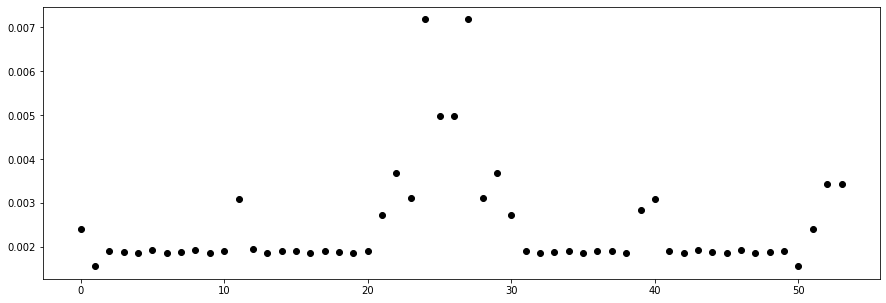

In [12]:
# Estimate reference parameters

# Set window
length = 4096
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Estimate frequency
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency

# Estimate amplitude for given frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude, phase = result.T

# Check maximum reconstruction error
result = []
for a, b in zip(amplitude, phase):
    result.append(Data.make_harmonic(length, frequency, a, b, dtype=dtype, device=device))
result = torch.stack(result)
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}, error={(d.data - result).abs().max().item():12.9}')

# Plot amplitude
plt.figure(figsize=(15, 5))
plt.scatter(range(54), amplitude.cpu(), color='black')
plt.show()

In [13]:
# Real TbT data length is limited by decoherence
# In this example 1024 turns are used for frequency estimation and only 256 for amplitude

# Set window
length = 1024
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Add random noise
n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536883215, spread=1.12389423e-06


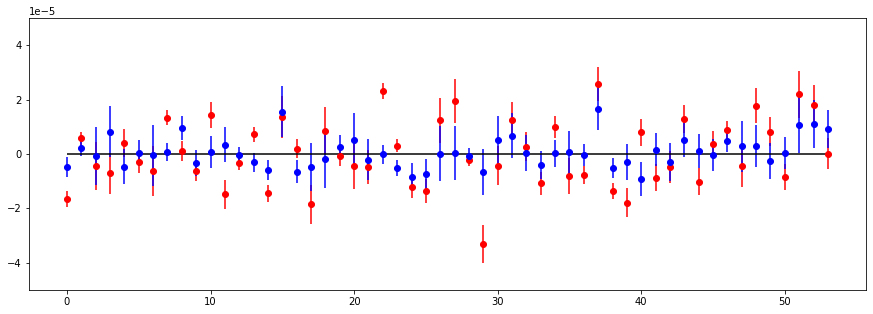

In [14]:
# Amplitude (and its error) can be estimated using harmonic_amplitude method
dec = Decomposition(d)

# Estimate amplitude and its spread using error propogation without window (noise is estimated using optimal SVD truncation)
out1, err1 = dec.harmonic_amplitude(frequency, length=256, order=0.0, error=True, sigma_frequency=spread)

# Estimate amplitude and its spread using error propogation with window
out2, err2 = dec.harmonic_amplitude(frequency, length=256, order=1.0, error=True, sigma_frequency=spread)

# Compare results
plt.figure(figsize=(15, 5))
plt.errorbar(range(54), (out1-amplitude).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.errorbar(range(54), (out2-amplitude).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

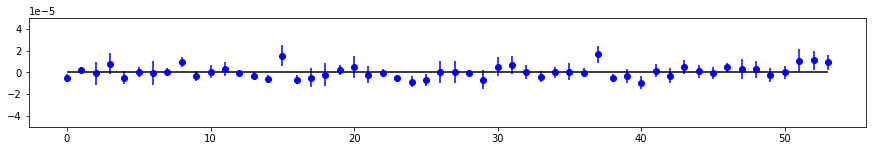

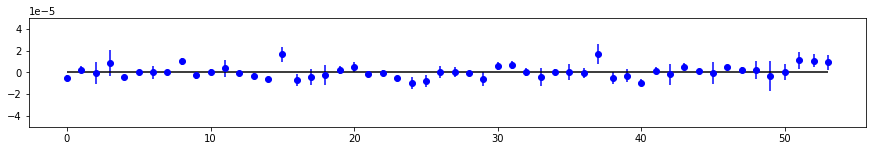

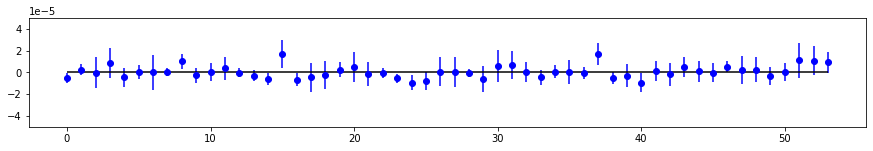

In [15]:
# Sampling can be used to improve estimation accuracy (sampling reduce effect of bias)
dec = Decomposition(d)

# Estimate amplitude and its spread using error propogation
out1, err1 = dec.harmonic_amplitude(frequency, length=256, order=1.0, error=True, sigma_frequency=spread)

# Estimate amplitude and its spread from shifted samples
out2, err2 = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=128, step=1, fit='none')
out3, err3 = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=128, step=1, fit='average')

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out1-amplitude).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out2-amplitude).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out3-amplitude).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

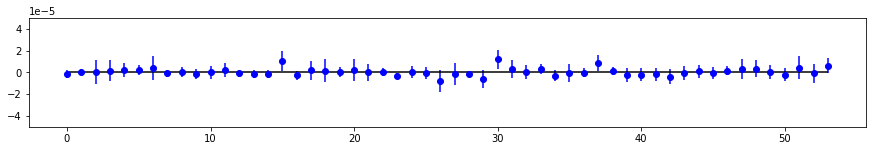

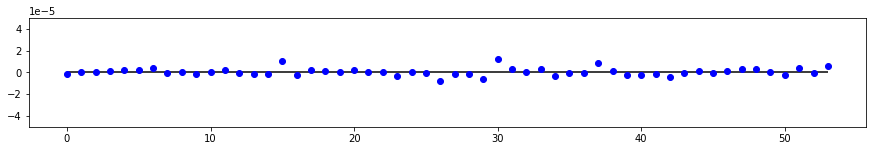

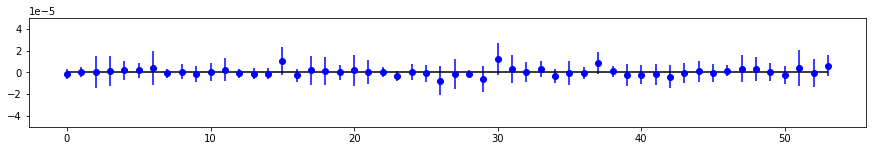

In [16]:
# Filter data
flt = Filter(d)
flt.filter_svd(rank=2)
flt.filter_hankel(rank=2, random=True, buffer=16, count=16)

# Estimate amplitude
dec = Decomposition(d)
out1, err1 = dec.harmonic_amplitude(frequency, length=256, order=1.0, error=True, sigma_frequency=spread)
out2, err2 = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=128, step=1, fit='none')
out3, err3 = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=128, step=1, fit='average')

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out1-amplitude).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out2-amplitude).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out3-amplitude).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

d.reset()

# Example-05: Phase estimation loop

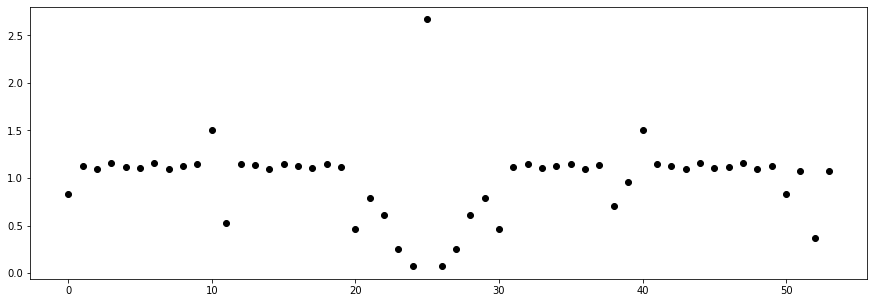

In [17]:
# Load model phase advance data
with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['S'])}

total = config['END']['FX']
model = torch.tensor([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR'], dtype=torch.float64)

# Plot adjacent phase advance
model, _ = Decomposition.advance_adjacent(total, model)
plt.figure(figsize=(15, 5))
plt.scatter(range(54), model.cpu().numpy(), color='black')
plt.show()

In [18]:
# Estimate reference parameters

# Set window
length = 4096
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Estimate frequency
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency

# Estimate amplitude for given frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude, phase = result.T

# Check maximum reconstruction error
result = []
for a, b in zip(amplitude, phase):
    result.append(Data.make_harmonic(length, frequency, a, b, dtype=dtype, device=device))
result = torch.stack(result)
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}, error={(d.data - result).abs().max().item():12.9}')

frequency= 0.536883099, spread=1.38725499e-16, error=2.56151871e-13


In [19]:
# Real TbT data length is limited by decoherence
# In this example 1024 turns are used for frequency estimation and only 512 for phase

# Set window
length = 1024
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Add random noise
n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536882912, spread=1.20856469e-06


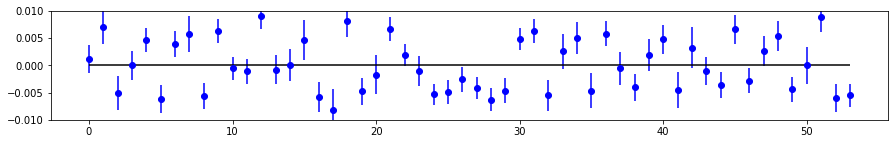

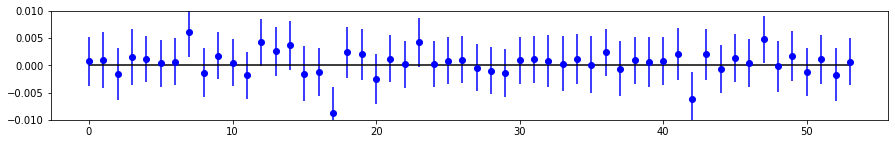

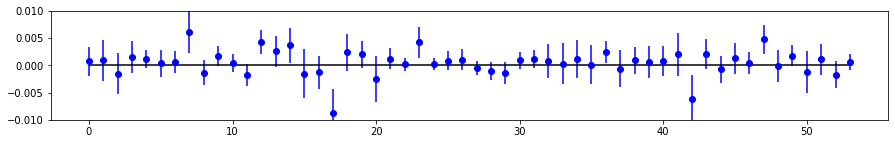

tensor(4.893410246695e-03, dtype=torch.float64)
tensor(2.351176787601e-03, dtype=torch.float64)
tensor(2.351176787601e-03, dtype=torch.float64)


In [20]:
# Estimate phase
dec = Decomposition(d)
out1, err1 = dec.harmonic_phase(frequency, length=512, order=0.0, error=True, sigma_frequency=spread)
out2, err2 = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=256, step=1, fit='none')
out3, err3 = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=256, step=1, fit='average')

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out1 - phase).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out2 - phase).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out3 - phase).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

print((out1 - phase).std())
print((out2 - phase).std())
print((out3 - phase).std())

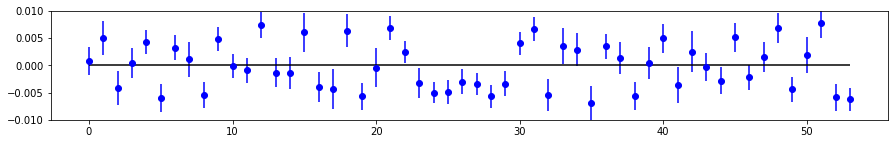

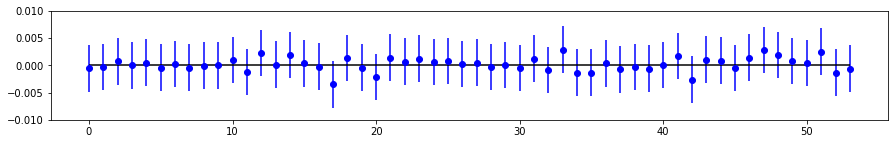

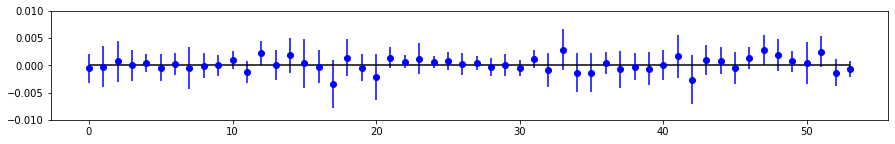

tensor(4.433662002218e-03, dtype=torch.float64)
tensor(1.263900832858e-03, dtype=torch.float64)
tensor(1.263900832858e-03, dtype=torch.float64)


In [21]:
# Estimate phase (filter)
flt = Filter(d)
flt.filter_svd(rank=2)
flt.filter_hankel(rank=2, random=True, buffer=16, count=16)
out1, err1 = dec.harmonic_phase(frequency, length=512, order=0.0, error=True, sigma_frequency=spread)
out2, err2 = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=256, step=1, fit='none')
out3, err3 = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=256, step=1, fit='average')

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out1 - phase).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out2 - phase).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out3 - phase).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

print((out1 - phase).std())
print((out2 - phase).std())
print((out3 - phase).std())

d.reset()

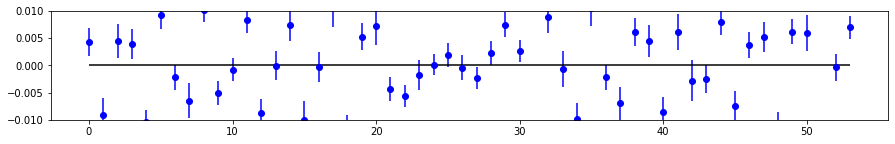

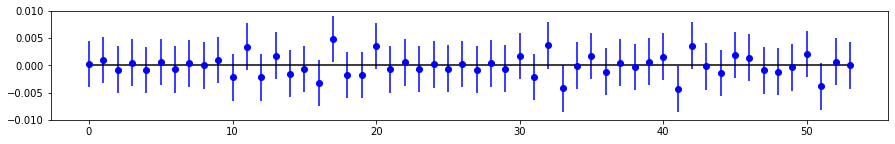

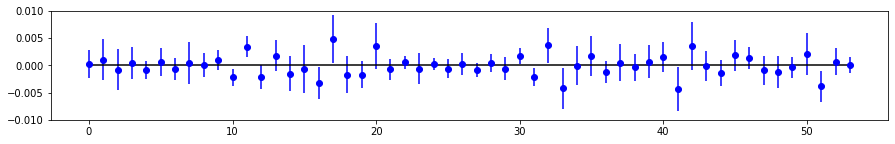

tensor(6.946303688450e-03, dtype=torch.float64)
tensor(1.921632117992e-03, dtype=torch.float64)
tensor(1.921632117992e-03, dtype=torch.float64)


In [22]:
# Compute and compare phase advance for the last case
add1, std1 = Decomposition.advance_adjacent(2.0*numpy.pi*frequency, out1, err1)
add2, std2 = Decomposition.advance_adjacent(2.0*numpy.pi*frequency, out2, err2)
add3, std3 = Decomposition.advance_adjacent(2.0*numpy.pi*frequency, out3, err3)


plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (add1 - model).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (add2 - model).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (add3 - model).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

print((add1 - model).std())
print((add2 - model).std())
print((add3 - model).std())

# Example-06: Synchronization check & phase correction

In [23]:
# In this example synchonization error (wrong starting turn) and corresponding phase correction is presented
# Separate function is available in Twiss class

In [24]:
# Load phase advance data
with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['S'])}
advance = numpy.array([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR' or key == 'END'])
advance = numpy.diff(advance)

In [25]:
# Set window
length = 1024
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data
table = numpy.load('../virtual_tbt.npy')

# Set correct starting position for all signals
start = 128

# Set synchronization errors
# If shifted in + by one, need to - for correction
# If shifted in - by one, need to + for correction
error = {10: 127, 31: 129, 32:129, 41:127, 43:129}

# Set data
d = torch.zeros((54, length), dtype=dtype, device=device)
for i in range(54):
    first = start if i not in error else error[i]
    d[i] = torch.tensor(table[i, first: first + length])
d = Data.from_data(w, d)

# Add random noise
n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536883076, spread=1.00760019e-06


0
8.53688307602922
12.53688307602922


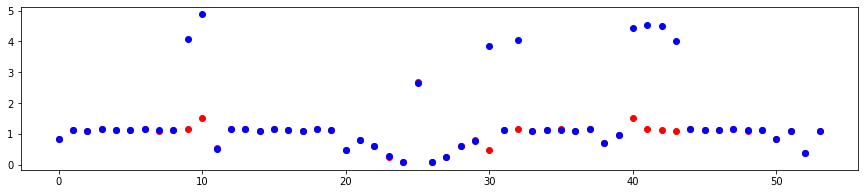

In [26]:
# Estimate phase and compute phase advance
dec = Decomposition(d)
out, _ = dec.harmonic_phase(frequency, length=512, order=0.0)
add, _ = Decomposition.advance_adjacent(2.0*numpy.pi*frequency, out)

# Negative advance might be used as indicator (not robust)
print(len(add[add < 0]))

# Total advance might be used as indicator in some cases (not robust)
print((8.0 + frequency).item())
print((add.sum()/(2.0*numpy.pi)).item())

# Plot phase advance
plt.figure(figsize=(15, 3))
plt.scatter(range(54), advance, color='red')
plt.scatter(range(54), add, color='blue')
plt.show()

In [27]:
# To perform a more robust test & correction, the following is assumed:

# A) most of signals have no synchronization error
# B) signal can be off only by one turn in any direction
# C) without synchronization errors phase advance is close to model (some threshold can be specified)

# With these assumptions, it is possible to identify signals that might have a synchronization error
# To do this, pairs with large advance error are marked (based on robust dispersion or other methods, see below)
# Other pairs are assumed to be correct
# Signals at the endpoints are correct
# Select adjacent signal with correct phase and right marked signal, check the effect of adding or subtracting of one turn
# If such correction results in significant improvement, change corresponding phase (starting position might not be avalible)
# Do this for all marked signals

# If synchronization error is indeed present, results should match for both planes

# Ones corrected, tests can be performed again (e.g. when not all pairs are marked initialy)

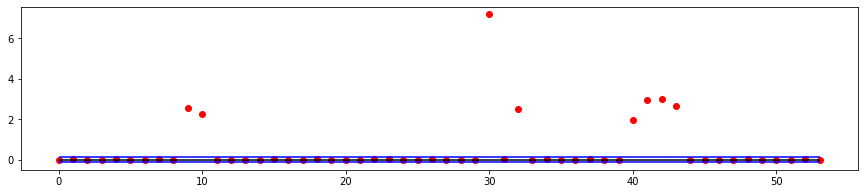

In [28]:
# Plot difference from the model model
delta = (add-advance)/advance

q25 = torch.quantile(delta, 0.25).cpu().numpy()
q50 = torch.quantile(delta, 0.50).cpu().numpy()
q75 = torch.quantile(delta, 0.75).cpu().numpy()

l, u = q25 - 10.0*(q75 - q25), q75 + 10.0*(q75 - q25)

plt.figure(figsize=(15, 3))
plt.scatter(range(54), delta.cpu().numpy(), color='red')
plt.hlines(q50, 0, 53, colors='black')
plt.hlines(l, 0, 53, colors='blue')
plt.hlines(u, 0, 53, colors='blue')
plt.show()

In [29]:
# LOF
from sklearn.neighbors import LocalOutlierFactor
detector = LocalOutlierFactor(contamination=0.05)
pairs = detector.fit_predict(delta.reshape(-1, 1))
pairs, *_ = numpy.in1d(delta, delta[pairs == -1]).nonzero()
pairs = [[i, i + 1] for i in tuple(pairs)]
print(pairs)

[[30, 31], [41, 42], [42, 43]]


In [30]:
# IFO
from sklearn.ensemble import IsolationForest
detector = IsolationForest(contamination=0.05)
pairs = detector.fit_predict(delta.reshape(-1, 1))
pairs, *_ = numpy.in1d(delta, delta[pairs == -1]).nonzero()
pairs = [[i, i + 1] for i in tuple(pairs)]
print(pairs)

[[30, 31], [40, 41], [42, 43]]


In [31]:
# DBSCAN
from sklearn.cluster import DBSCAN
from collections import Counter
cluster = DBSCAN().fit(delta.reshape(-1, 1))
label, *_ = Counter(cluster.labels_)
pairs, *_ = numpy.in1d(delta, delta[cluster.labels_ != label]).nonzero()
pairs = [[i, i + 1] for i in tuple(pairs)]
print(pairs)

[[9, 10], [10, 11], [30, 31], [32, 33], [40, 41], [41, 42], [42, 43], [43, 44]]


In [32]:
# Pairs outside acceptance region
l_p, *_ = numpy.where(delta < l)
u_p, *_ = numpy.where(delta > u)
marked = (*tuple(l_p), *tuple(u_p))
marked = [[i, i + 1] for i in marked]
print(marked)

[[9, 10], [10, 11], [30, 31], [32, 33], [40, 41], [41, 42], [42, 43], [43, 44]]


In [33]:
# Marked signals
table = []
chain = []
for i in numpy.unique(numpy.array(pairs).flatten()):
    if chain == []:
        chain.append(i)
        value = i
        continue
    if i == value + 1:
        chain.append(i)
        value = i
        continue
    table.append(chain)
    chain = []
    chain.append(i)
    value = i
else:
    table.append(chain)
print(table)
    
# Remove endpoints
table = [*map(lambda x: x[1:-1], table)]
print(table)

# Set marked and passed
marked = [j for i in table for j in i]
passed = [i for i in range(54) if i not in marked]

# Set phase
phase = torch.clone(out)

# Correct
for i in marked:
    phase_x = phase[i-1]
    phase_y = phase[i]
    phase_y = phase_y + torch.stack([-2.0*numpy.pi*frequency, 0.0*numpy.pi*frequency, +2.0*numpy.pi*frequency])
    phase_y = Frequency.mod(phase_y, 2*numpy.pi, -numpy.pi)
    delta = Frequency.mod(phase_y - phase_x, 2*numpy.pi)
    delta = torch.abs(delta - advance[i-1])
    index = delta.argmin().item()
    print(f"{i}: {['+', ' ', '-'][index]}, {128 + [+1, 0, -1][index]}")
    phase[i] = phase_y[index]
    
print(error)

[[9, 10, 11], [30, 31, 32, 33], [40, 41, 42, 43, 44]]
[[10], [31, 32], [41, 42, 43]]
10: -, 127
31: +, 129
32: +, 129
41: -, 127
42:  , 128
43: +, 129
{10: 127, 31: 129, 32: 129, 41: 127, 43: 129}


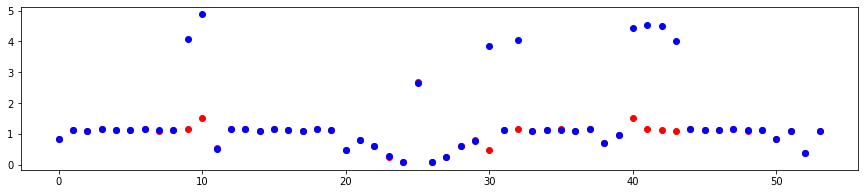

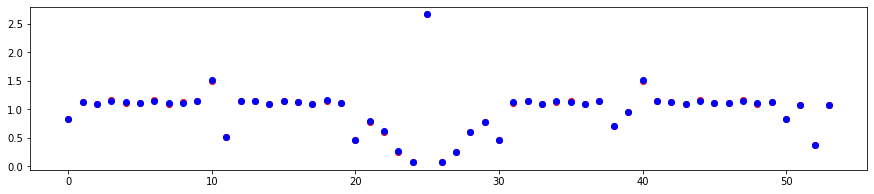

In [34]:
# Plot advance using corrected phase

plt.figure(figsize=(15, 3))
plt.scatter(range(54), advance, color='red')
plt.scatter(range(54), add, color='blue')
plt.show()

correct, _ = Decomposition.advance_adjacent(2.0*numpy.pi*frequency, phase)
plt.figure(figsize=(15, 3))
plt.scatter(range(54), advance, color='red')
plt.scatter(range(54), correct, color='blue')
plt.show()

# Example-07: Estimation of parameters with DHT

In [35]:
# Estimate reference parameters

# Set window
length = 4096
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Estimate frequency
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency

# Estimate amplitude for given frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude, phase = result.T

# Check maximum reconstruction error
result = []
for a, b in zip(amplitude, phase):
    result.append(Data.make_harmonic(length, frequency, a, b, dtype=dtype, device=device))
result = torch.stack(result)
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}, error={(d.data - result).abs().max().item():12.9}')

frequency= 0.536883099, spread=1.38725499e-16, error=2.56151871e-13


In [36]:
# Real TbT data length is limited by decoherence

# Set window
length = 512
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Add random noise
n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536883812, spread=2.68329455e-06


In [37]:
# Filter data
flt = Filter(d)
flt.filter_svd(rank=2)
flt.filter_hankel(rank=2, random=True, buffer=16, count=16)

# DHT
dht = Frequency.dht(d.work)

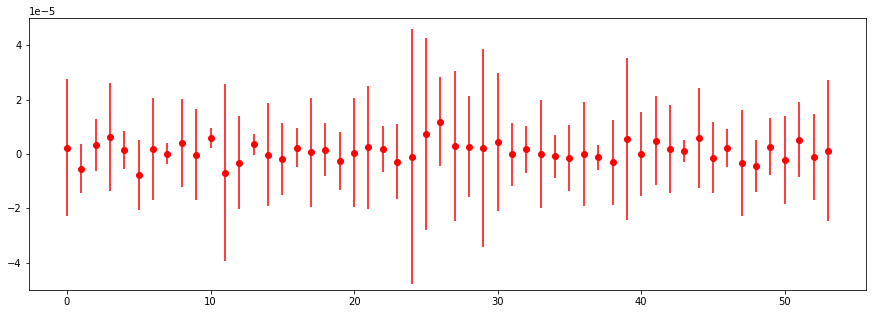

In [38]:
# Compute envelope
envelope = dht.abs()

# Estimate amplitude
endpoint = 16
estimate = envelope[:, +endpoint:-endpoint].mean(1)
spread = envelope[:, +endpoint:-endpoint].std(1)

# Compare
plt.figure(figsize=(15, 5))
plt.errorbar(range(54), (estimate - amplitude).cpu().numpy(), yerr=spread.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

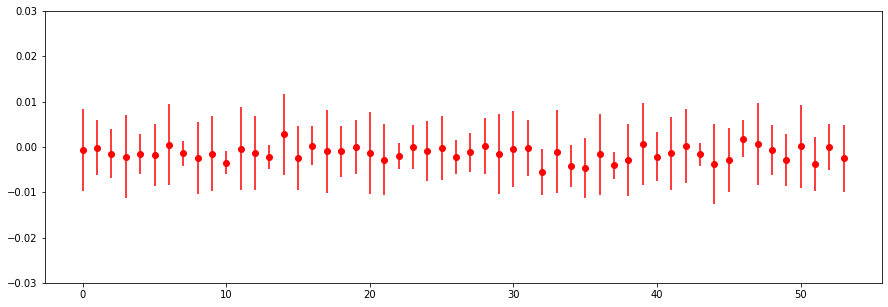

In [39]:
# Estimate phase
angle = dht.angle()
endpoint = 16
angle -= 2.0*numpy.pi*frequency*torch.linspace(0, length - 1, length, dtype=dtype, device=device)
angle = Frequency.mod(angle, 2.0*numpy.pi, -numpy.pi)
estimate = angle[:, +endpoint:-endpoint].mean(1)
spread = angle[:, +endpoint:-endpoint].std(1)

# Compare
plt.figure(figsize=(15, 5))
plt.errorbar(range(54), (estimate - phase).cpu().numpy(), yerr=spread.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.ylim(-3.0E-2, +3.0E-2)
plt.show()